In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.io import read_image
import os
import torch.nn as nn

import torchvision.transforms as transforms

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy
from google.colab import drive
drive.mount('/content/drive')

batch_size = 16
transform = transforms.Compose(
    [transforms.Resize((50,50)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



TRAIN_DATA_PATH = "/content/drive/MyDrive/traindata/"
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
#adding augmented data
augmented_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform = transforms.Compose([
                      transforms.Resize((50,50)),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15)]))
train_aug_data = torch.utils.data.ConcatDataset([train_data, augmented_data])
#train_size = int(0.8 * len(train_data))
#train_size = int(0.8 * len(augmented_data))
train_size = int(0.8 * len(train_aug_data))
val_size = len(train_aug_data) - train_size
#val_size = len(train_data) - train_size
#val_size = len(augmented_data) - train_size

train_set, val_set = random_split(train_aug_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))
#train_set, val_set = random_split(train_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = 2)

val_data_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers = 2)


classes = ('cherry', 'strawberry', 'tomato')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


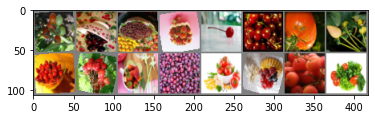

tomato cherry cherry strawberry cherry cherry tomato strawberry cherry cherry strawberry cherry tomato strawberry cherry tomato


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

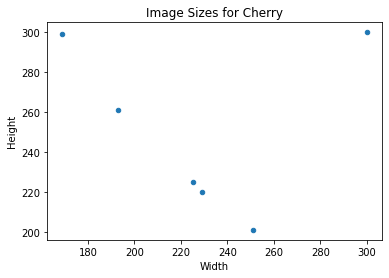

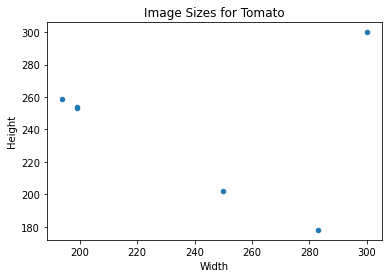

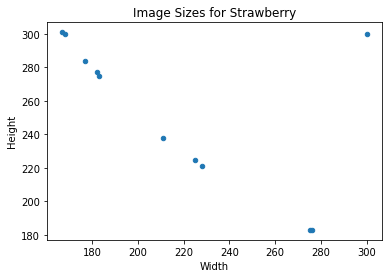

In [ ]:
import dask.bag as bag
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os



#resize the images if needed
def get_dims(file):
  #Returns dimenstions for an RBG image
  im = Image.open(file)
  h,w = im.size
  return h,w

#directory for getting the files in each class
paths = {'Cherry': '/content/drive/MyDrive/traindata/cherry/',
'Tomato': '/content/drive/MyDrive/traindata/tomato/',
'Strawberry': '/content/drive/MyDrive/traindata/strawberry/'}

for i,y in paths.items():
  filepath = y
  files = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(files).map(get_dims)
  
  dims = dims.compute()
  dim_df = pd.DataFrame(dims, columns=['Height', 'Width'])
  dim_df["File Path"] = files;
  sizes = dim_df.groupby(['Height', 'Width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='Width', y='Height');
  plt.title('Image Sizes for {}'.format(i))

In [ ]:
STRAWBERRY_DATA_PATH = TRAIN_DATA_PATH+"/strawberry"
CHERRY_DATA_PATH = TRAIN_DATA_PATH+"/cherry"
TOMATO_DATA_PATH = TRAIN_DATA_PATH+"/tomato"
number_classes = {'straw': len(os.listdir(STRAWBERRY_DATA_PATH)),
'cherry': len(os.listdir(CHERRY_DATA_PATH)),
'tomato': len(os.listdir(TOMATO_DATA_PATH))}
number_classes
#can see there is an even distribution in the training set which is good

#when looking through images I noticed that some of them would not be very useful for image classification, 
#for example there is a picture of a girl with a small cherry tattoo and that is classed as cherry, there is also
#an image of two drinks/cocktails with a small strawberry in the drink and that is classed as strawberry.
#SHOULD SHOW EXAMPLES OF THEM IN REPORT

{'straw': 1439, 'cherry': 1451, 'tomato': 1455}

In [ ]:
#MLP
class OtherNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Flatten(),nn.Linear(50*50*3, batch_size), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(batch_size, 10), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(10, 3))

    def forward(self, x):
        # here we define the (forward) computational graph,
        # in terms of the tensors, and elt-wise non-linearities
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [ ]:
#function to get the accuracy (evaluate) of the model 
def get_accuracy(model, eval_loader, train_loader, device):

    model.eval()
    eval_correct = 0
    eval_total = 0
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        # Evaluate the model on the validation set
        for input, target in eval_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            _, predictions = torch.max(output, 1)
            eval_correct += (predictions == target).sum().item()
            eval_total += target.size(0)

        # Evaluate the model on the training set
        for input, target in train_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            _, predictions = torch.max(output, 1)
            train_correct += (predictions == target).sum().item()
            train_total += target.size(0)

    return eval_correct/eval_total, train_correct/train_total

In [ ]:
#function to train the model over different epochs and plots the loss and accuracy
import time
batch_32_train_accuracy = []
batch_32_val_accuracy = []
batch_32_train_loss = []
batch_32_val_loss =  []
batch_64_train_accuracy = []
batch_64_val_accuracy = []
batch_64_train_loss = []
batch_64_val_loss =  []
train_loss_list = [] 
val_loss_list = []
val_accuracy_list = []
train_accuracy_list = []
def train_model(model, criterion, optimizer, train_loader, eval_loader, epoch_count, device):

    print("Start training...")
    start_time = time.time()
    epochs = list(range(1,epoch_count+1))
    val_accuracy_list = []
    train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    for epoch in range(epoch_count):  

        train_running_loss = []
        val_running_loss = []
        highest_eval_acc = 0
        highest_eval_acc_epoch = 0

        model.train()
        for i, (inputs, target) in enumerate(train_loader, 0):
          # get the inputs; using GPU
            inputs, target = inputs.to(device), target.to(device)
            #target = target.unsqueeze(1)
          # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
   
            loss = criterion(outputs, target)
 
            loss.backward()
            optimizer.step()

            train_running_loss.append(loss.item())
            
        #get the accuracy
        eval_accuracy, train_accuracy = get_accuracy(
            model, val_data_loader, train_data_loader, device)
          
        for i, (inputs2, target2) in enumerate(eval_loader, 0): #maybe look at this as plot seems too correlated
          inputs2, target2 = inputs2.to(device), target2.to(device)
          #optimizer.zero_grad()
          #target2 = target2.unsqueeze(1)
          outputs2 = model(inputs2) 
          loss2 = criterion(outputs2, target2)
          loss2.backward()
          #optimizer.step()
          val_running_loss.append(loss2.item())

      
      #print accuracy at this epoch
        if(epoch % 1 == 0):
            print("Epoch " + str(epoch) + ": " + str(eval_accuracy))

      #saving the best model based off the accuracy of validation
        if eval_accuracy > highest_eval_acc:
            highest_eval_acc = eval_accuracy
            highest_epoch = epoch
            #PATH = './mlp_net.pth'
            torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")
      
      #add accuracy and loss to lists
        train_loss_list.append(sum(train_running_loss)/len(train_running_loss))
        val_loss_list.append(sum(val_running_loss)/len(val_running_loss))
        val_accuracy_list.append(eval_accuracy)
        train_accuracy_list.append(train_accuracy)

        #batch_64_train_loss.append(sum(train_running_loss)/len(train_running_loss))
        #batch_64_val_loss.append(sum(val_running_loss)/len(val_running_loss))
        #batch_64_val_accuracy.append(eval_accuracy)
        #batch_64_train_accuracy.append(train_accuracy)

  # Print time
    print('Time taken: {:.2f} minutes'.format(
          (time.time() - start_time) / 60))
  
    print('Training has finished') 

  #plot loss
    plt.plot(epochs, train_loss_list, label = "train loss")
    plt.plot(epochs, val_loss_list, label = "val loss")
    plt.title("Loss (average) when training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

  #plot accuracy
    plt.plot(epochs, val_accuracy_list, label = "val accuracy")
    plt.plot(epochs, train_accuracy_list, label = "train accuracy")
    plt.title("Accuracy on the validation set")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    print(highest_epoch)

    #return train_loss_list, val_loss_list, val_accuracy_list, train_accuracy_list

In [ ]:
import torch.optim as optim

#make a device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#make the MLP model
model = OtherNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#train the MLP model
train_model(model, criterion, optimizer, train_data_loader, val_data_loader, 10, device)

Using cuda device


NameError: ignored

In [ ]:
#CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1296, 500) 
        #self.fc1 = nn.Linear(1296, batch_size)
        self.fc2 = nn.Linear(500, 100)
       # self.fc2 = nn.Linear(64, 10)
        self.fc3 = nn.Linear(100, 3) #number of classes is 3

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.softmax(self.conv1(x), dim=1))
        #x = self.pool(F.softmax(self.conv2(x), dim=1))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.softmax(self.fc1(x), dim=1)
        #x = F.softmax(self.fc2(x), dim=1)
        x = self.fc3(x)
        
        #x = F.softmax(self.fc3(x), dim=1) #need for negative log loss function
        return x


#net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

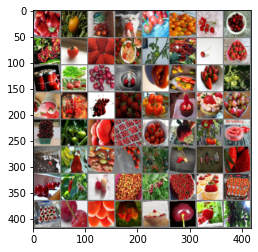

GroundTruth:  strawberry tomato tomato strawberry cherry tomato cherry cherry cherry tomato strawberry tomato tomato tomato cherry strawberry


In [ ]:
dataiter = iter(val_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net().to(device)
PATH = "/content/drive/MyDrive/model.pth"
net.load_state_dict(torch.load(PATH))
model = torch.load(PATH)

In [ ]:

images = images.to(device)
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:s}'
                              for j in range(5)))

Predicted:  tomato cherry cherry cherry cherry


In [ ]:
#testing the accuracy of the model (after it has been trained and saved (run the very bottom cell to do this.))
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 77 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cherry is 80.5 %
Accuracy for class: strawberry is 73.0 %
Accuracy for class: tomato is 78.7 %


Using cuda device
Start training...
Epoch 0: 0.34810126582278483
Epoch 1: 0.4234752589182969
Epoch 2: 0.4441887226697353
Epoch 3: 0.4936708860759494
Epoch 4: 0.5149597238204833
Epoch 5: 0.5512082853855006
Epoch 6: 0.5322209436133487
Epoch 7: 0.5638665132336018
Epoch 8: 0.570771001150748
Epoch 9: 0.5632911392405063
Epoch 10: 0.5788262370540852
Epoch 11: 0.5909090909090909
Epoch 12: 0.593210586881473
Epoch 13: 0.5960874568469505
Epoch 14: 0.5960874568469505
Epoch 15: 0.6070195627157653
Epoch 16: 0.6052934407364787
Epoch 17: 0.595512082853855
Epoch 18: 0.5989643268124281
Epoch 19: 0.6121979286536249
Epoch 20: 0.6098964326812428
Epoch 21: 0.5926352128883774
Epoch 22: 0.5558112773302647
Epoch 23: 0.6127733026467204
Epoch 24: 0.61795166858458
Epoch 25: 0.619102416570771
Epoch 26: 0.6219792865362486
Epoch 27: 0.6346375143843498
Epoch 28: 0.6041426927502876
Epoch 29: 0.6472957422324511
Epoch 30: 0.643843498273878
Epoch 31: 0.6415420023014959
Epoch 32: 0.6421173762945915
Epoch 33: 0.63348676639

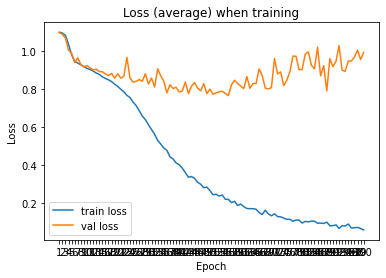

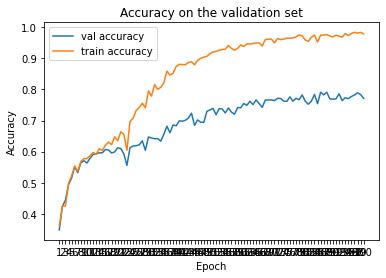

99


In [ ]:
#testing the accuracy over different amounts of epochs
import torch.optim as optim
#make a device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#make the MLP model
model = Net().to(device) 
criterion = nn.CrossEntropyLoss()

#criterion = nn.CTCLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay = 0.0005)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

#train the MLP model
train_model(model, criterion, optimizer, train_data_loader, val_data_loader, 100, device)